<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [2]:
push!(LOAD_PATH, ".")
using RobustOptimization
using Ipopt, JuMP, PyPlot
using ScikitLearn
@sk_import model_selection: train_test_split
@sk_import metrics: roc_curve
@sk_import metrics: roc_auc_score
@sk_import metrics: accuracy_score
@sk_import metrics: classification_report
path_train = "datasets/ionosphere_scale"
nbfeatures = 34
data_train = read_data_libsvm(path_train, nbfeatures);
# xtr, xte, ytr, yte = train_test_split(data_train[:,1:end-1], data_train[:,end], train_size = 0.15)
# ab_train = hcat(xtr, ytr)
# aux_train = ab_train[ab_train[:,end] .< 0,:]
# ll_train = vcat(aux_train,data_train[data_train[:,end].>0,:])
rs = 75
xtr, xte, ytr, yte = train_test_split(data_train[:,1:end-1], data_train[:,end], train_size = 0.6, random_state = rs)
df_train = hcat(xtr, ytr)
# low_train = hcat(xtr, ytr)
df_aux= hcat(xte, yte);
xtr = nothing
xte = nothing
ytr = nothing
yte = nothing
gc()

In [3]:
# df_train, df_aux = create_data("diabetes_scale", nbfeatures, 0.2, train_test_split)
solver = IpoptSolver(print_level = 2)
N = size(df_train)[1]
ϵ = 0.05
verbosity = 50
itmax = 2000
sample = 100

ambiguity = "KLdivergence"
robustModel = RobustModel(N, nbfeatures, ϵ, ambiguity, LogisticRegression())
# α = 1/norm(robustModel.descent_direction)
α = 0.01
projParams = ProjParams(Int(40), 1e-5, sample, para_proj=Sequential(), para_inter=Sequential())
optParams = OptParams(itmax, 1e-5, α, verbosity = verbosity);

xnormal = normal_opt(df_train, solver, robustModel.regressionModel)
fpr, tpr, thresholds = roc_curve(df_aux[:,end], positive_rate(xnormal,df_aux))

# e_tab = [0.001]
e_tab = [0.0001,0.0005,0.0006,0.0007,0.0008,0.0009,0.001,0.002,0.003,0.004,0.005,
            0.006,0.007,0.008,0.009,0.01,0.05,0.1,0.5]

xr1_tab = []
fpr1_tab = []
tpr1_tab = []
for ϵ in e_tab
    println(" ")
    println("espilon = ", ϵ)
    println(" ")
    robustModel = RobustModel(N, nbfeatures, ϵ, ambiguity, LogisticRegression())
    xrobust1 = KL_opt(df_train, ϵ, solver, robustModel.regressionModel)
    fpr1, tpr1, thresholds = roc_curve(df_aux[:,end], positive_rate(xrobust1,df_aux))
    push!(xr1_tab, xrobust1)
    push!(fpr1_tab, fpr1)
    push!(tpr1_tab, tpr1)
end


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

 
espilon = 0.0001
 
 
espilon = 0.0005
 
 
espilon = 0.0006
 
 
espilon = 0.0007
 
 
espilon = 0.0008
 
 
espilon = 0.0009
 
 
espilon = 0.001
 
 
espilon = 0.002
 
 
espilon = 0.003
 
 
espilon = 0.004
 
 
espilon = 0.005
 
 
espilon = 0.006
 
 
espilon = 0.007
 
 
espilon = 0.008
 
 
espilon = 0.009
 
 
espilon = 0.01
 
 
espilon = 0.05
 
 
espilon = 0.1
 
 
espilon = 0.5
 


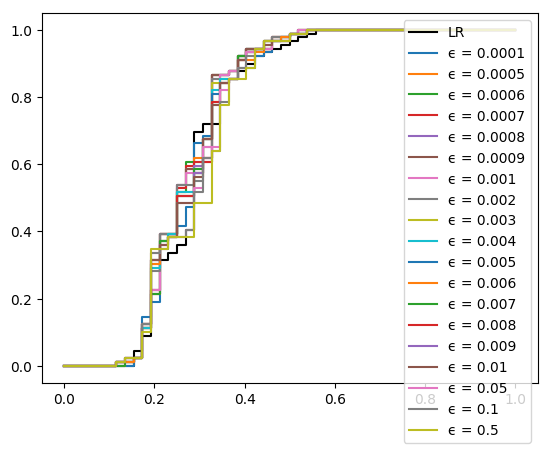

PyObject <matplotlib.legend.Legend object at 0x7fb464e88eb8>

In [42]:
plot(fpr,tpr, color="black", label="LR")
for i in 1:size(e_tab)[1]
     plot(fpr1_tab[i], tpr1_tab[i], label="ϵ = $(e_tab[i])")
end
legend()

0.7134831460674158  0.7943262411347518


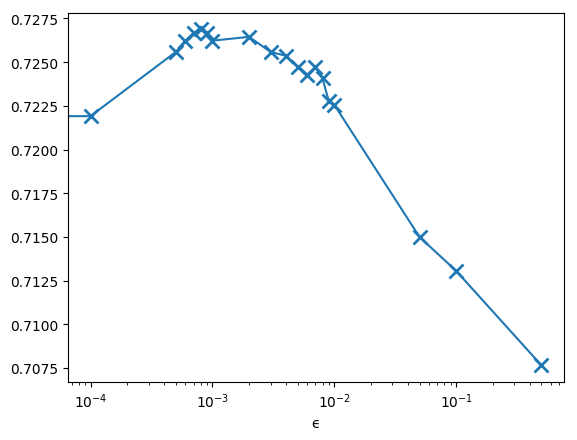

0.7219101123595506  0.8085106382978723
0.7255834053586863  0.8014184397163121
0.7262316335350043  0.8014184397163121
0.7266637856525497  0.8014184397163121
0.7268798617113224  0.8014184397163121
0.7266637856525497  0.8014184397163121
0.7262316335350043  0.8014184397163121
0.726447709593777  0.8085106382978723
0.7255834053586863  0.8085106382978723
0.7253673292999137  0.8014184397163121
0.7247191011235955  0.8014184397163121
0.7242869490060502  0.8014184397163121
0.7247191011235955  0.8014184397163121
0.7240708729472775  0.8014184397163121
0.7227744165946413  0.8014184397163121
0.7225583405358686  0.8014184397163121
0.7149956784788245  0.8085106382978723
0.7130509939498704  0.8085106382978723
0.7076490924805532  0.8085106382978723


PyObject Text(0.5, 24.0, 'ϵ')

In [5]:
plt_AUC = []
print(roc_auc_score(df_aux[:,end], positive_rate(xnormal,df_aux)))
push!(plt_AUC, roc_auc_score(df_aux[:,end], positive_rate(xnormal,df_aux)))
print("  ")
println(accuracy_score(df_aux[:,end], pred(df_aux, xnormal, LogisticRegression())))
for i in 1:size(e_tab)[1]
    print(roc_auc_score(df_aux[:,end], positive_rate(xr1_tab[i],df_aux)))
    push!(plt_AUC, roc_auc_score(df_aux[:,end], positive_rate(xr1_tab[i],df_aux)))
    print("  ")
    println(accuracy_score(df_aux[:,end], pred(df_aux, xr1_tab[i], LogisticRegression())))
end
plot(vcat([0], e_tab[1:end]), plt_AUC, marker = "x", mew = 2  , markersize = 10)
xscale("log")
xlabel("ϵ")

In [37]:
solver = IpoptSolver(print_level = 2)
N = size(df_train)[1]
ϵ = 0.05
verbosity = 1
itmax = 500
sample = 128

ambiguity = "wasserstein"
robustModel = RobustModel(N, nbfeatures, ϵ, ambiguity, LogisticRegression())
α = 1/norm(robustModel.descent_direction)
# @everywhere α = 1.0
projParams = ProjParams(Int(1000), 1e-5, sample, para_proj=Sequential(), para_inter=Sequential())
optParams = OptParams(itmax, 1e-5, α, verbosity = verbosity);

In [38]:
xnormal = normal_opt(df_train, solver, robustModel.regressionModel)
fpr, tpr, thresholds = roc_curve(df_aux[:,end], positive_rate(xnormal,df_aux))


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



([0.0, 0.0192308, 0.153846, 0.153846, 0.173077, 0.173077, 0.192308, 0.192308, 0.211538, 0.211538  …  0.480769, 0.5, 0.5, 0.519231, 0.519231, 0.538462, 0.538462, 0.557692, 0.557692, 1.0], [0.0, 0.0, 0.0, 0.0449438, 0.0449438, 0.0898876, 0.0898876, 0.213483, 0.213483, 0.314607  …  0.955056, 0.955056, 0.966292, 0.966292, 0.977528, 0.977528, 0.988764, 0.988764, 1.0, 1.0], [2.0, 1.0, 1.0, 0.999992, 0.999991, 0.999973, 0.999972, 0.999794, 0.999733, 0.998022  …  0.536114, 0.391011, 0.358508, 0.350994, 0.245074, 0.202028, 0.198651, 0.0562994, 0.0522239, 1.06549e-23])

In [7]:
# e_tab = [0.01]
e_tab = [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

16-element Array{Float64,1}:
 0.0001
 0.0005
 0.001 
 0.005 
 0.01  
 0.05  
 0.1   
 0.2   
 0.3   
 0.4   
 0.5   
 0.6   
 0.7   
 0.8   
 0.9   
 1.0   

In [33]:
fpr1_was = fp
tpr1_was = tp
xr1_was = xr

16-element Array{Any,1}:
 [0.175153, 0.0, 7.01722, 2.08887, 5.12731, 0.44447, -6.62745, 0.578785, -3.26129, -0.313039  …  -5.27163, 8.60643, -14.2585, -2.2321, 15.5868, 3.83424, 6.6358, 0.00722558, -7.15934, -4.07011]           
 [0.157787, 0.0, 6.99322, 2.08602, 5.0857, 0.467615, -6.58918, 0.553836, -3.22777, -0.303923  …  -5.19824, 8.47286, -14.087, -2.21225, 15.362, 3.80381, 6.56723, -0.00134789, -7.09813, -4.01461]          
 [0.135385, 0.0, 6.96327, 2.083, 5.03347, 0.498466, -6.54066, 0.52152, -3.1847, -0.291501  …  -5.10551, 8.30233, -13.8699, -2.18705, 15.0754, 3.76696, 6.47934, -0.0140003, -7.02066, -3.94298]            
 [-0.173213, 0.0, 6.95381, 2.17401, 4.7516, 0.735801, -6.33842, 0.299835, -2.85977, -0.144701  …  -4.6605, 7.38053, -12.6501, -2.16488, 13.3735, 3.57936, 6.01588, -0.0996851, -6.61876, -3.37519]         
 [-0.157408, 0.0, 5.99382, 1.93166, 4.62108, 0.31429, -5.40632, 0.350365, -2.44591, 0.0884716  …  -4.81035, 7.44568, -12.789, -2.16699, 13.0335, 3.75925, 5.842

In [23]:
print(size(fp))
print(size(tp))
print(size(xr))

(7,)(7,)(7,)

In [7]:
function auxaux(df_train, ϵ, solver, robustModel, df_aux, xr1_was, fpr1_was, tpr1_was)
    println(" ")
    println("espilon = ", ϵ)
    println(" ")
    xrobust1 = DRO_opt(df_train, ϵ, solver, robustModel.regressionModel)
    fpr1, tpr1, thresholds = roc_curve(df_aux[:,end], positive_rate(xrobust1,df_aux))
    push!(xr1_was, xrobust1)
    push!(fpr1_was, fpr1)
    push!(tpr1_was, tpr1)
end

auxaux (generic function with 1 method)

In [8]:
# dm_was = []
# xr1_was = []
# fpr1_was = []
# tpr1_was = []
for ϵ in e_tab[15:16]
# for ϵ in [0.001,0.005,0.01]
    println(" ")
    println("espilon = ", ϵ)
    println(" ")
    xrobust1 = DRO_opt(df_train, ϵ, solver, robustModel.regressionModel)
    fpr1, tpr1, thresholds = roc_curve(df_aux[:,end], positive_rate(xrobust1,df_aux))
    push!(xr1_was, xrobust1)
    push!(fpr1_was, fpr1)
    push!(tpr1_was, tpr1)
end

 
espilon = 0.2
 
 
espilon = 0.9
 


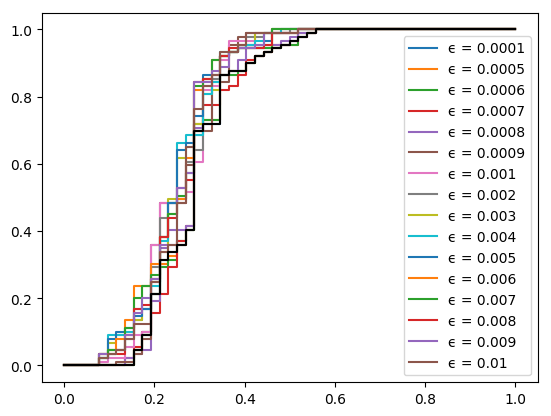

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fb464e2cef0>

In [45]:
for i in 1:16
     plot(fpr1_was[i], tpr1_was[i], label="ϵ = $(e_tab[i])")
end
legend()
plot(fpr,tpr, color="black", label="LR")

0.7134831460674158  0.7943262411347518


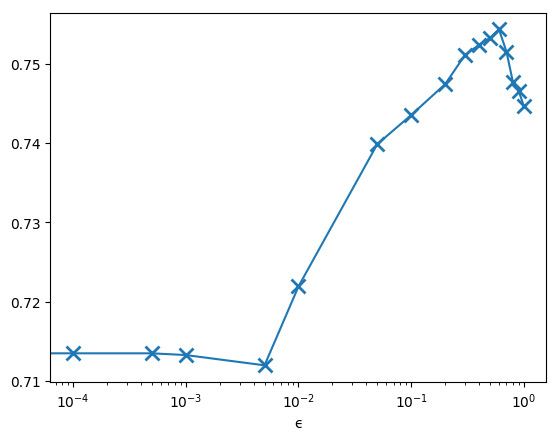

0.7134831460674158  0.7943262411347518
0.7134831460674158  0.7943262411347518
0.7132670700086431  0.7943262411347518
0.7119706136560069  0.8014184397163121
0.7219101123595506  0.8226950354609929
0.7398444252376837  0.8368794326241135
0.7435177182368193  0.8297872340425532
0.7474070872947278  0.8297872340425532
0.7510803802938635  0.8368794326241135
0.7523768366464995  0.8226950354609929
0.7532411408815903  0.8085106382978723
0.7543215211754537  0.8226950354609929
0.7515125324114088  0.8156028368794326
0.7476231633535004  0.8085106382978723
0.746542783059637  0.8297872340425532
0.7445980985306828  0.8297872340425532


PyObject Text(0.5, 24.0, 'ϵ')

In [8]:
plt_was = []
push!(plt_was,roc_auc_score(df_aux[:,end], positive_rate(xnormal,df_aux)))
print(roc_auc_score(df_aux[:,end], positive_rate(xnormal,df_aux)))
print("  ")
println(accuracy_score(df_aux[:,end], pred(df_aux, xnormal, LogisticRegression())))
for i in 1:16
    push!(plt_was,roc_auc_score(df_aux[:,end], positive_rate(xr1_was[i],df_aux)))
    print(roc_auc_score(df_aux[:,end], positive_rate(xr1_was[i],df_aux)))
    print("  ")
    println(accuracy_score(df_aux[:,end], pred(df_aux, xr1_was[i], LogisticRegression())))
end
plot(vcat([0], e_tab[1:16]), plt_was, marker = "x", mew = 2  , markersize = 10)
xscale("log")
xlabel("ϵ")

In [51]:
open("io-ipopt-was.txt", "w") do f
    write(f, "xnormal = ")
    write(f, "$xnormal \n")
    write(f, "fpr = ")
    write(f, "$fpr \n")
    write(f, "tpr = ")
    write(f, "$tpr \n")
#     write(f, "dm_tab = ")
#     write(f, "$dm_tab \n")
    write(f, "xr1_tab = ")
    write(f, "$xr1_tab \n")
    write(f, "fpr1_tab = ")
    write(f, "$fpr1_tab \n")
    write(f, "tpr1_tab = ")
    write(f, "$tpr1_tab \n")
#     write(f, "dm_was = ")
#     write(f, "$dm_was \n")
    write(f, "xr1_was = ")
    write(f, "$xr1_was \n")
    write(f, "fpr1_was = ")
    write(f, "$fpr1_was \n")
    write(f, "tpr1_was = ")
    write(f, "$tpr1_was \n")
end

5783